In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os, sys, pickle, copy, pygmt, operator

from pathlib import Path
from time import sleep
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

import seaborn as sns; sns.set()
sns.set_theme(style="white")

#from joblib import Parallel, delayed
#import multiprocessing
#import numba as nb
#from numba import jit

from sklearn.feature_selection import RFECV,RFE
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score

from sklearn.metrics import make_scorer, explained_variance_score, mean_absolute_error, mean_squared_error, \
r2_score, max_error, median_absolute_error, mean_absolute_percentage_error


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder , PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector


In [3]:
# constanst
crs_to='epsg:4326'
crs_from='epsg:4326'
projection = 'M5.4i'
#parent directory

DIR = Path().resolve() 

plt_params = {
    'legend.fontsize': 50,
    "axes.edgecolor" : "black", 
    "axes.linewidth" : 2.50, 
    #plt.rcParams.update({'font.size': 20})

    'xtick.labelsize': 50,
    'ytick.labelsize': 50,
    "axes.labelsize" : 50,
}

# We can exclude Arctic ocean and Antarctica, as there are no HF measurements to use
world_lon_min, world_lon_max, world_lat_min, world_lat_max  = -180, 180, -60, 80

# map extents of Africa and Australia
afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max =  -20, 52, -37 , 38  


# create grid for each region
# crs Coordinate reference system

#EPSG is projection
# 0.2 degrees equal roughly 20 km

region_afr = [afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max]
region_world = [world_lon_min, world_lon_max, world_lat_min, world_lat_max]




In [4]:

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [5]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    
    y_true = y_true.ravel().reshape(-1,)
    y_pred = y_pred.ravel().reshape(-1,)
    # Remove NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

In [6]:
obs = pd.DataFrame()


obs["OBS_REF"] = ["CTD" ,  "SI","LAB", "MOHO",
            "SV","PV", 
            "GEOID","FA","DEM","BG", "EMAG2_CLASS",
                   "RHO_L", "RHO_C", 
                  "VOLC_DIST_W", "REG", "GLIM"]

obs["OBS_AFR"] = ["CTD" ,  "SI","LAB", "MOHO",
            "SV_Velocity","PV_Velocity", 
            "GEOID","FA","DEM","BG", "EMAG2",
                   "RHO_L", "RHO_C", 
                  "VOLC_DIST", "REG", "GLIM"]
  
     
# Labels for plots etc


# Labels for plots etc
obs["LABELS_gmt"] = ["CTD",  "Shape index", "LAB", "Moho", 
                "S@_v@ 150km", "P@_v@ 150km", 
                "Geoid", "Free air", "DEM", "Bouguer", "Mag.", 
                "Lith. rho", "Crust rho",  
                 "Volcano", "REG", "GliM", ]  


obs["LABELS"] = ["CTD",  "Shape index", "LAB", "Moho", 
                "$S_v$ @150km", "$P_v$ @150km", 
                "Geoid", "Free air", "DEM", "Bouguer", "Mag.", 
                "Lith. ρ", "Crust ρ",  
                 "Volcano", "REG", "GliM", ]
    
# "vp/vs"
# Units to display in plots etc
obs["UNITS"] = ["km",  "si", "km", "km",
             "$\delta$$S_v$ %","$\delta$$P_v$ %", 
             "m", "mGal", "m", "mGal",  "f(nT)", 
                 "kg/m$^3$", "kg/m$^3$",
                "km",  "class", "class"]



obs["UNITS_gmt"] = ["km",  "si", "km", "km",
             "km/s","km/s", 
             "m", "mGal", "m", "mGal",  "f(nT)", 
                 "kg/m@+3@+", "kg/m@+3@+",
                "km",  "class", "class"]
        
# Range of colormap for plots. Similar data are placed in same ranges for consistancy
obs["V_RANGE"] = [(0,50), (-1,1),(0,300),(15,60),
              (-0.075,0.075), (-0.02,0.02), 
              (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-0.4, 0.4), 
                   (3260, 3360), (2650, 2950),
                  (0,1), (1,6),(1,16),]


    
obs["V_RANGE_AFR"] = [(0,50), (-1,1),(50,250),(20,50),
          (-0.075,0.075), (-0.02,0.02), 
          (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-200, 200), 
               (3260, 3360), (2650, 2950),
              (0,100), (1,6),(1,15),]


obs["CMAPS"] = ["batlow",  "broc", "bamako", "batlow", 
             "roma","roma", 
             "bamako", "broc", "bukavu", "broc", "batlow",            
                "batlow", "batlow",
               "bamako",  "batlowS","categorical", ]

obs["CMAPS"] = ["SCM/bamako",  "SCM/broc", "SCM/bamako", "SCM/bamako", 
             "SCM/roma","SCM/roma", 
             "SCM/bamako", "SCM/broc", "SCM/oleron", "SCM/broc", "SCM/bilbao",            
                "SCM/batlow", "SCM/batlow",
               "SCM/broc",  "gmt/categorical","gmt/categorical", ]

new_index = [0,1,2,3,4,5,6,8,7,9,10,11,12,13,14,15]

#new_index = [4,3,15,6,7,0, 14, 10,16, 8, 9,2, 13, 12, 8, 11, ]

obs = obs.reindex(new_index)

#obs.index = np.arange(0,len(obs))

pd.options.display.width = 370
pd.options.display.max_colwidth = 16




obs_dict = obs.to_dict(orient='records')

obs.set_index(['OBS_REF'], inplace=True)



obs

OBS_AFR   LABELS_gmt        LABELS            UNITS  UNITS_gmt          V_RANGE      V_RANGE_AFR            CMAPS
OBS_REF                                                                                                                           
CTD                  CTD          CTD           CTD               km         km          (0, 50)          (0, 50)       SCM/bamako
SI                    SI  Shape index   Shape index               si         si          (-1, 1)          (-1, 1)         SCM/broc
LAB                  LAB          LAB           LAB               km         km         (0, 300)        (50, 250)       SCM/bamako
MOHO                MOHO         Moho          Moho               km         km         (15, 60)         (20, 50)       SCM/bamako
SV           SV_Velocity  S@_v@ 150km  $S_v$ @150km  $\delta$$S_v$ %       km/s  (-0.075, 0.075)  (-0.075, 0.075)         SCM/roma
PV           PV_Velocity  P@_v@ 150km  $P_v$ @150km  $\delta$$P_v$ %       km/s    (-0.02, 0.02)    (-0.02, 0.02)         SCM/roma
GEOID              GEOID        Geoid         Geoid                m          m        (-45, 45)        (-45, 45)       SCM/bamako
DEM                  DEM          DEM           DEM                m          m    (-2200, 2200)    (-2200, 2200)       SCM/oleron
FA                    FA     Free air      Free air             mGal       mGal      (-100, 100)      (-100, 100)         SCM/broc
BG                    BG      Bouguer       Bouguer             mGal       mGal      (-100, 100)      (-100, 100)         SCM/broc
EMAG2_CLASS        EMAG2         Mag.          Mag.            f(nT)      f(nT)      (-0.4, 0.4)      (-200, 200)       SCM/bilbao
RHO_L              RHO_L    Lith. rho       Lith. ρ         kg/m$^3$  kg/m@+3@+     (3260, 3360)     (3260, 3360)       SCM/batlow
RHO_C              RHO_C    Crust rho       Crust ρ         kg/m$^3$  kg/m@+3@+     (2650, 2950)     (2650, 2950)       SCM/batlow
VOLC_DIST_W    VOLC_DIST      Volcano       Volcano               km         km           (0, 1)         (0, 100)         SCM/broc
REG                  REG          REG           REG            class      class           (1, 6)           (1, 6)  gmt/categorical
GLIM                GLIM         GliM          GliM            class      class          (1, 16)          (1, 15)  gmt/categorical

In [7]:
#ds_afr_lr = xr.load_dataset(DIR/'Grids'/'Inputs'/"ds_afr_lr.nc")
ds_afr_hr = xr.load_dataset(DIR/'Grids'/'Inputs'/"ds_afr_hr.nc")
#ds_world = xr.load_dataset(dir_p/'Grids'/'inputs'/"ds_world.nc")



In [8]:

target = 'GHF'
coord = ['lon', 'lat']
grid_index_world = 'grid_index_world'
grid_index_afr ='grid_index_afr'

hq_lower_bound = 25
hq_upper_bound = 100


#######

features_ex = []
features_ghf = []


features = obs.index.to_list()


in_features = set(features)

features_ex = copy.deepcopy(features)
features_ex.extend(coord)
features_ex.append(grid_index_world)
features_ex.append(grid_index_afr)


features_ex.append(target)
features_ghf = copy.deepcopy(features)
features_ghf.append(target)


features_ex

['CTD',
 'SI',
 'LAB',
 'MOHO',
 'SV',
 'PV',
 'GEOID',
 'DEM',
 'FA',
 'BG',
 'EMAG2_CLASS',
 'RHO_L',
 'RHO_C',
 'VOLC_DIST_W',
 'REG',
 'GLIM',
 'lon',
 'lat',
 'grid_index_world',
 'grid_index_afr',
 'GHF']

In [9]:


rating = 'ra'
outlier = 'OD'


file_label = f'{outlier}_{rating}'

w_OD_ra_f =  DIR/'Dataset'/'Preprocessed'/f'W_OD_ra.csv'
W_OD_ra = pd.read_csv(w_OD_ra_f, sep='\t')


Afr_OD_ra_hr_f =  DIR/'Dataset'/'Preprocessed'/f'Afr_OD_ra_hr.csv'
Afr_OD_ra_hr = pd.read_csv(Afr_OD_ra_hr_f,  sep='\t')


Afr_NOD_ra_hr_f =  DIR/'Dataset'/'Preprocessed'/f'Afr_NOD_ra_hr.csv'
Afr_NOD_ra_hr = pd.read_csv(Afr_NOD_ra_hr_f,sep='\t')


#######


W_OD_ra['GLIM']  = W_OD_ra['GLIM'].astype('category')
W_OD_ra['REG']  = W_OD_ra['REG'].astype('category')

Afr_OD_ra_hr['GLIM']  = Afr_OD_ra_hr['GLIM'].astype('int').astype('category')
Afr_OD_ra_hr['REG']   = Afr_OD_ra_hr['REG'].astype('int').astype('category')

Afr_NOD_ra_hr['GLIM']  = Afr_NOD_ra_hr['GLIM'].astype('int').astype('category')
Afr_NOD_ra_hr['REG']   = Afr_NOD_ra_hr['REG'].astype('int').astype('category')


#####

X_w = W_OD_ra[features]
y_w = W_OD_ra[target].values.reshape(-1,1) 


X_afr_hr = Afr_OD_ra_hr[features]
y_afr_hr = Afr_OD_ra_hr[target].values.reshape(-1,1) 


####



bs_rfr_hyp_df = pd.read_csv(DIR/'Hyperparameters'/f'BS_hyperparameter.csv', sep='\t')


best_params = bs_rfr_hyp_df.to_dict('r')[0]

print(file_label)


print(len(Afr_OD_ra_hr))
print(len(W_OD_ra))


X_afr_hr.describe(include='all')

OD_ra
784
5565


CTD          SI         LAB        MOHO          SV          PV       GEOID          DEM          FA          BG  EMAG2_CLASS        RHO_L        RHO_C  VOLC_DIST_W    REG   GLIM
count   784.000000  784.000000  784.000000  784.000000  784.000000  784.000000  784.000000   784.000000  784.000000  784.000000   784.000000   784.000000   784.000000   784.000000  784.0  784.0
unique         NaN         NaN         NaN         NaN         NaN         NaN         NaN          NaN         NaN         NaN          NaN          NaN          NaN          NaN    6.0   11.0
top            NaN         NaN         NaN         NaN         NaN         NaN         NaN          NaN         NaN         NaN          NaN          NaN          NaN          NaN    1.0   16.0
freq           NaN         NaN         NaN         NaN         NaN         NaN         NaN          NaN         NaN         NaN          NaN          NaN          NaN          NaN  419.0  486.0
mean     28.324828    0.018031  133.819972   33.775472    0.022766    0.002746   10.791946    81.315051    2.733208  -10.196684     0.017117  3320.835600  2786.384223     0.001508    NaN    NaN
std       5.213734    0.396880   39.390652    4.617290    0.029832    0.006416   10.464684   615.559293   22.368278   63.591371     0.129183    30.930472    33.960413     0.024342    NaN    NaN
min      21.404036   -0.877965   66.089399   15.807076   -0.040644   -0.012987  -16.271496 -1221.000000  -32.209390 -153.854285    -1.000000  3262.868753  2720.312991     0.000000    NaN    NaN
25%      24.878120   -0.321703   78.682078   31.226871   -0.005528   -0.002622    6.031570  -114.000000  -21.218302  -25.763054    -0.015721  3274.969825  2756.083223     0.000000    NaN    NaN
50%      26.403527    0.032858  154.831628   33.972514    0.036460    0.004438    9.662890   -39.000000    1.940855    9.265677     0.036147  3339.410570  2782.196716     0.000000    NaN    NaN
75%      29.645397    0.266174  165.748988   35.961792    0.044598    0.004680   14.354782   293.000000   23.149794   26.447523     0.081267  3343.261777  2798.787093     0.000000    NaN    NaN
max      48.635906    0.932651  177.836248   46.957553    0.070700    0.031186   50.341217  1843.000000   64.371454  124.856139     0.436619  3367.060786  2878.547924     0.394020    NaN    NaN

In [10]:
def nrmse(y_true, y_pred):
    cost  = mean_squared_error(y_true, y_pred, squared=False)
    return cost/(y_true.mean()) 

def accuracy(y_true, y_pred):
    cost  = mean_absolute_percentage_error(y_true, y_pred)
    return (100 - cost) * 100

def min_e(y_true, y_pred):
    cost  = abs(y_test - y_predict)
    return cost.min()

def mpe(y_true, y_pred):
    return (np.mean((y_test -y_predict)/y_test) , 2)



scores_cv = {

'RMSE'     :  make_scorer(mean_squared_error , squared=False),
#'NRMSE'    :  make_scorer(nrmse),
'MAE'      :  make_scorer(mean_absolute_error),    
#'MAPE'     :  make_scorer(mean_absolute_percentage_error ),
#'ACC'      :  make_scorer(accuracy) ,
'MPE'      :  make_scorer(mpe),
'CD'       :  make_scorer(r2_score),
#'EV'       :  make_scorer(explained_variance_score),
#'MAX_E'    :  make_scorer( max_error),
#'MIN_E'    :  make_scorer(min_e),
#'MedAE'    :  make_scorer(median_absolute_error),
#'CCC'      :  make_scorer(concordance_correlation_coefficient),
    
}


# Pre-evalaution Africa

In [11]:
cv = 3

KPI_afr_hr= pd.DataFrame()


for best_features in tqdm_notebook(
    range(8,16), desc = 'Processing: '):


    regressor = RandomForestRegressor()
    
    tuned_params = {item[11:]: best_params[item] for item in best_params}
    regressor.set_params(**tuned_params)


    rfe = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

    numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("reducer", rfe),   ("regressor", regressor)]

    
    # Initialize Pipeline object
    pipeline= Pipeline(steps = steps)
    
    #pipeline.set_params(**best_params)

    
    
    for key, scoring in tqdm_notebook( scores_cv.items(), desc='Scoring: ' ):
    
        KPI_afr_lr.loc[key,f'{best_features}_{file_label}']  = np.mean(cross_validate(
                    pipeline, 
                    X_afr_hr, 
                    y_afr_hr,
                    scoring=scoring,
                      cv=cv)['test_score'])
  

    
    # Print message to user
    print('#'*60)



####16 faetures


best_features = 16

regressor = RandomForestRegressor()

tuned_params = {item[11:]: best_params[item] for item in best_params}
regressor.set_params(**tuned_params)


rfe = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


preprocessor = ColumnTransformer(
    transformers=[
   ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
steps=[("preprocessor", preprocessor), ("reducer", rfe), ("regressor", regressor)]


# Initialize Pipeline object
pipeline= Pipeline(steps = steps)

pipeline.set_params(**best_params)
for key, scoring in tqdm_notebook( scores_cv.items(), desc='Scoring: ' ):

    KPI_afr_lr.loc[key, f'{best_features}_{file_label}']  = np.mean(cross_validate(
                pipeline, 
                X_afr_hr, 
                y_afr_hr,
                scoring=scoring,
                  cv=cv)['test_score'])

# Print message to user
print('#'*60)





Processing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 featu

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 fe

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 fe

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 fe

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 fe

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 16 fe

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
############################################################


Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
############################################################


Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [18]:


####16 faetures


best_features = 16

regressor = RandomForestRegressor()

tuned_params = {item[11:]: best_params[item] for item in best_params}
regressor.set_params(**tuned_params)


rfe = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)


numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


preprocessor = ColumnTransformer(
    transformers=[
   ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
steps=[("preprocessor", preprocessor), ("reducer", rfe), ("regressor", regressor)]


# Initialize Pipeline object
pipeline= Pipeline(steps = steps)

pipeline.set_params(**best_params)
for key, scoring in tqdm_notebook( scores_cv.items(), desc='Scoring: ' ):

    KPI_afr_lr.loc[key, f'str({best_features})_{file_label}']  = np.mean(cross_validate(
                pipeline, 
                X_afr_hr, 
                y_afr_hr,
                scoring=scoring,
                  cv=cv)['test_score'])

# Print message to user
print('#'*60)





Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

############################################################


  0%|          | 0/16 [00:00<?, ?it/s]

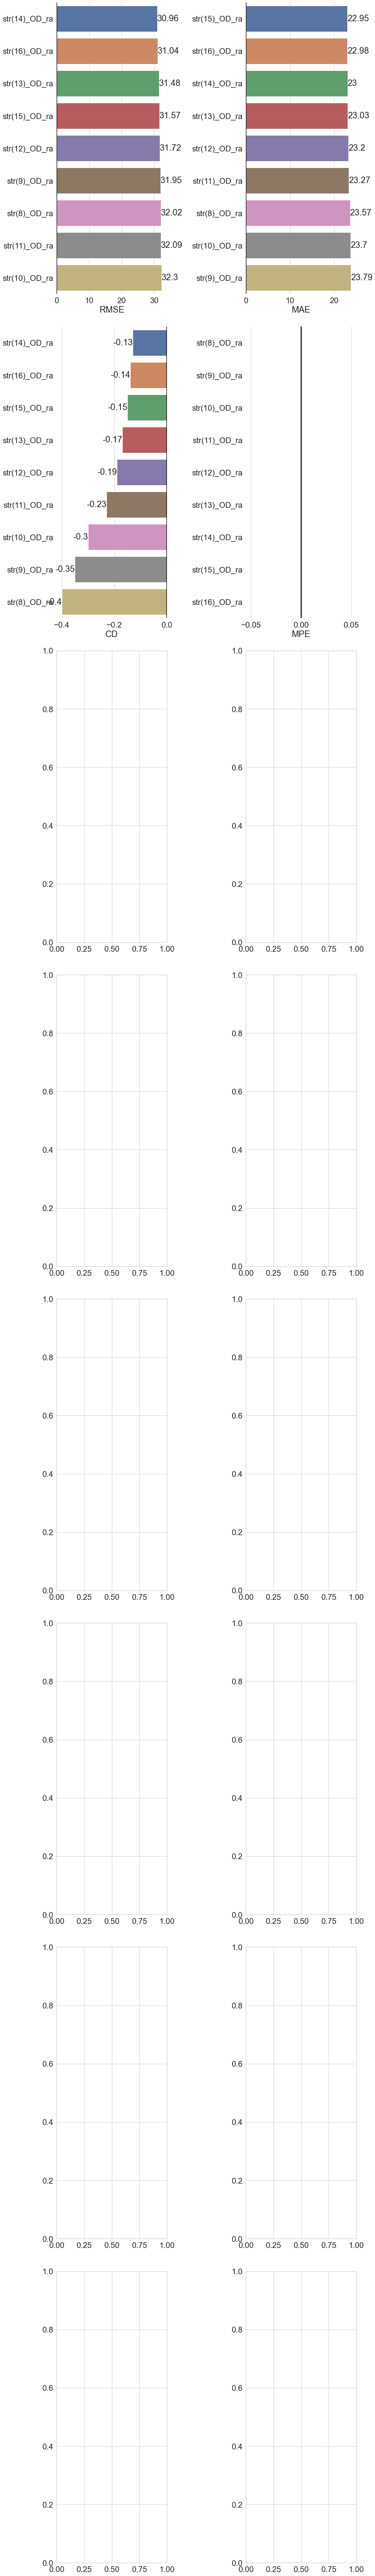

In [16]:


# Initialize auc_score dictionary

# Set figure size and create barplot

fig, axs = plt.subplots(8,2,figsize=(15, 100))

plt.rcParams.update(plt_params)




sns.set(style="whitegrid", color_codes=True, font_scale = 2)
#fig.set_size_inches(30,30)

#scores = ['RMSE', 'NRMSE','MAE', 'MAPE', 'CD','EV', 'MAX_E','MIN_E' ,'MedAE', 'MPE']

scores = ['RMSE', 'MAE', 'NRMSE','MAPE', 'CD','EV', 'MAX_E', 'MAX', 
          'Stdev', 'RSD', 'Mean','Median','MedAE', 'MPE', 'ACC', 'CCC']

scores = ['RMSE', 'MAE',  'CD', 'MPE']

for score, ax in tqdm_notebook(zip(scores, axs.flatten()), total = len(scores)):


   
    cols  = KPI_afr_lr.loc[score,:].sort_values(ascending=False).index.tolist()


    if score in ['CD','EV' ,'MAX', 'MPE', 'ACC','CCC']:
        
        
        x_data = KPI_afr_lr.loc[score,cols].sort_values(ascending=False).index
        y_data = KPI_afr_lr.loc[score,cols].sort_values(ascending=False).round(2)
        bar = sns.barplot(y_data[:], x_data[:] ,     ax=ax)
        bar.bar_label(ax.containers[0])

        # Generate a bolded horizontal line at y = 0
        ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

        # Turn frame off
        ax.set_frame_on(False)

        #ax.legend(loc='upper left')

        # Tight layout
        plt.tight_layout()
    else:
        x_data = KPI_afr_lr.loc[score,cols].sort_values().index
        y_data = KPI_afr_lr.loc[score,cols].sort_values().round(2)
        bar = sns.barplot(y_data[:], x_data[:] ,     ax=ax)
        bar.bar_label(ax.containers[0], )

        # Generate a bolded horizontal line at y = 0
        ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

        # Turn frame off
        ax.set_frame_on(False)

        #ax.legend(loc='upper left')

        # Tight layout
        plt.tight_layout()



In [20]:
#rfecv this process is more stable
 
kfold = 5

cv = KFold(n_splits=kfold, random_state=None, shuffle=True)

# Define a function to calculate negative RMSE (as a score)
def nrmse(y_true, y_pred):
    cost  = mean_squared_error(y_true, y_pred, squared=False)
    return cost/(y_true.mean())

#scoring = make_scorer(nrmse , greater_is_better=False )
nrmse_score = make_scorer(nrmse , greater_is_better=False)
r2 = make_scorer(r2_score)
#scoring = make_scorer(nrmse , greater_is_better=False )
#ccc_score = make_scorer(concordance_correlation_coefficient , greater_is_better=True)

scorings = {
    'NRMSe':nrmse_score,
    #'RMSE':'neg_root_mean_squared_error', 
    #'MAE':'neg_mean_absolute_error', 
    #'MAPE':'neg_mean_absolute_percentage_error', 
    'R2':r2,
    #'EV':'explained_variance'   
    #'$p_c$': ccc_score,    
}


results_cv ={}

tuned_params = {item[11:]: best_params[item] for item in best_params}
regressor.set_params(**tuned_params)


for key, score in scorings.items():
    regressor = RandomForestRegressor()
    
    regressor = RandomForestRegressor(random_state=None)

    tuned_params = {item[11:]: best_params[item] for item in best_params}
    regressor.set_params(**tuned_params)

    numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("rfecv", RFECV(regressor, 
                                    cv = cv, step = 1, #n_jobs=-1, 
                             scoring = score, verbose = 1))]


    # Initialize Pipeline object
    pipeline= Pipeline(steps = steps)



    # Initialize RFECV object
    #feature_selector = RFECV(pipeline['regressor'], cv = cv, step = 1, #n_jobs=-1, 
    #                         scoring = score, verbose = 1)
    

    # Fit RFECV
    pipeline.fit(X_afr_hr, np.ravel(y_afr_hr))
    #feature_selector .fit(X_w, np.ravel(y_w))
    results_cv[key] = pipeline

    # Get selected features
    #feature_names = X_train_corr.columns
    #selected_features = feature_names[feature_selector.support_].tolist()

    print(f'terminated {key} {score}\n')
    print('terminated')



Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fittin

In [21]:
# get RFECV progression score
score_progression = pd.DataFrame()
score_progression["NRMSe_RFECV"] = results_cv['NRMSe']['rfecv'].cv_results_['mean_test_score'] * -1
score_progression["R2_RFECV"] = results_cv['R2']['rfecv'].cv_results_['mean_test_score']
score_progression["n_features"]= list(range(1,17))
score_progression = score_progression.set_index("n_features")
score_progression

NRMSe_RFECV  R2_RFECV
n_features                       
1              0.261876  0.724851
2              0.227577  0.802542
3              0.220169  0.802929
4              0.212711  0.810203
5              0.214063  0.812383
6              0.214625  0.811049
7              0.212620  0.812659
8              0.214371  0.812840
9              0.211170  0.814269
10             0.210909  0.818242
11             0.209180  0.820669
12             0.208796  0.820954
13             0.209117  0.821184
14             0.207967  0.821608
15             0.208573  0.822543
16             0.207999  0.823447

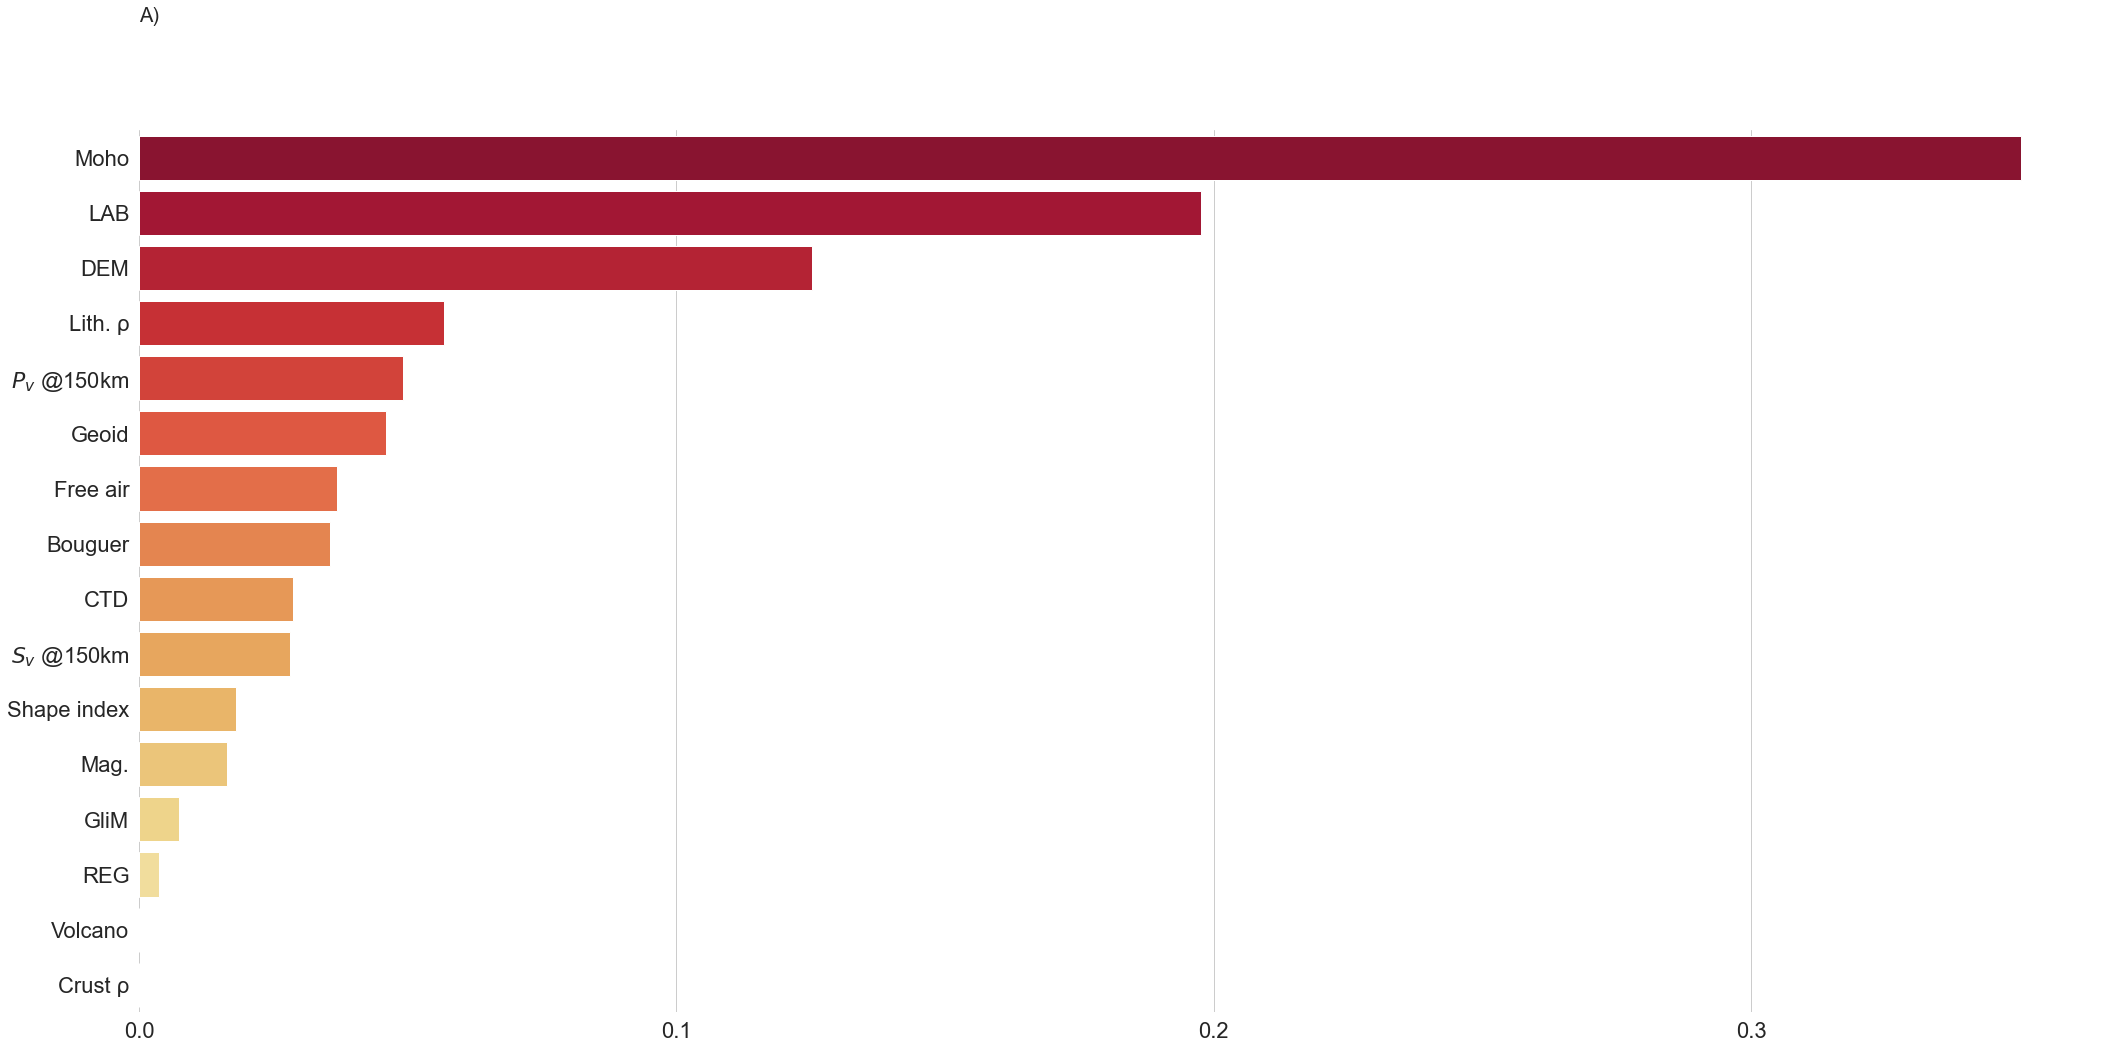

In [22]:
#feature importance 
# Get selected features data set
# should be scaled

sub_figs = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

# Set figure size and create barplot
#sns.set(style="whitegrid", color_codes=True, font_scale = 1.8)
fig, ax = plt.subplots( figsize=(30, 15))


plt.rcParams.update(plt_params)



feature_importance = pd.DataFrame()
 


# Load hyper parameter 

regressor = RandomForestRegressor()

numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


preprocessor = ColumnTransformer(
    transformers=[
   ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
steps=[("preprocessor", preprocessor), ("regressor", regressor)]


# Initialize Pipeline object
pipeline= Pipeline(steps = steps)

pipeline.set_params(**best_params)


pipeline.fit(X_afr_hr,y_afr_hr)



obs = obs.reset_index(drop=False).set_index('OBS_REF')

# Get feature importance
feature_importance["RI"] = pipeline['regressor'].feature_importances_
feature_importance["LABELS"]= obs.loc[features , 'LABELS'].values

feature_importance.set_index('LABELS', inplace=True)


# Sort by feature importance
feature_importance = feature_importance.sort_values(by="RI", ascending=False)


feature_importance["CUMSUM"] = feature_importance["RI"].cumsum()

score_progression["CUMSUM"] = feature_importance["CUMSUM"].values

sns.barplot(x = feature_importance["RI"].values, 
            y = feature_importance["RI"].index, ax=ax,
            palette = reversed(sns.color_palette('YlOrRd', 16)),  data = feature_importance)


ax.set_ylabel('')


# Turn frame off
ax.set_frame_on(False)
ax.locator_params(axis='x', nbins=7)


ax.set_title(f'{sub_figs[0]})', loc ='left', pad=20, size=20,  y=1.1)




# Tight layout
plt.tight_layout()


# Save Figure
#fig.savefig(dir_p/ 'fig'/"fig_5.jpeg", bbox_inches='tight', dpi=300 )

In [23]:
# individual RFECV to calculate conribution of each feature to R2 and NRMSe

for feature in obs.index:

    print(feature)


    X_train_afr_hr_feature = X_afr_hr[feature].to_frame()

    regressor = RandomForestRegressor()

    numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("regressor", regressor)]


    # Initialize Pipeline object
    pipeline= Pipeline(steps = steps)

    pipeline.set_params(**best_params)

    for key, scoring in scorings.items():
        feature_importance.loc[obs.loc[feature, 'LABELS'], key] = np.mean(cross_validate(
            pipeline, 
            X_train_afr_hr_feature, 
            y_afr_hr,
            scoring=scoring,
              cv=cv)['test_score'])


feature_importance = feature_importance.abs() 

print('terminated')

CTD
SI
LAB
MOHO
SV
PV
GEOID
DEM
FA
BG
EMAG2_CLASS
RHO_L
RHO_C
VOLC_DIST_W
REG
GLIM
terminated


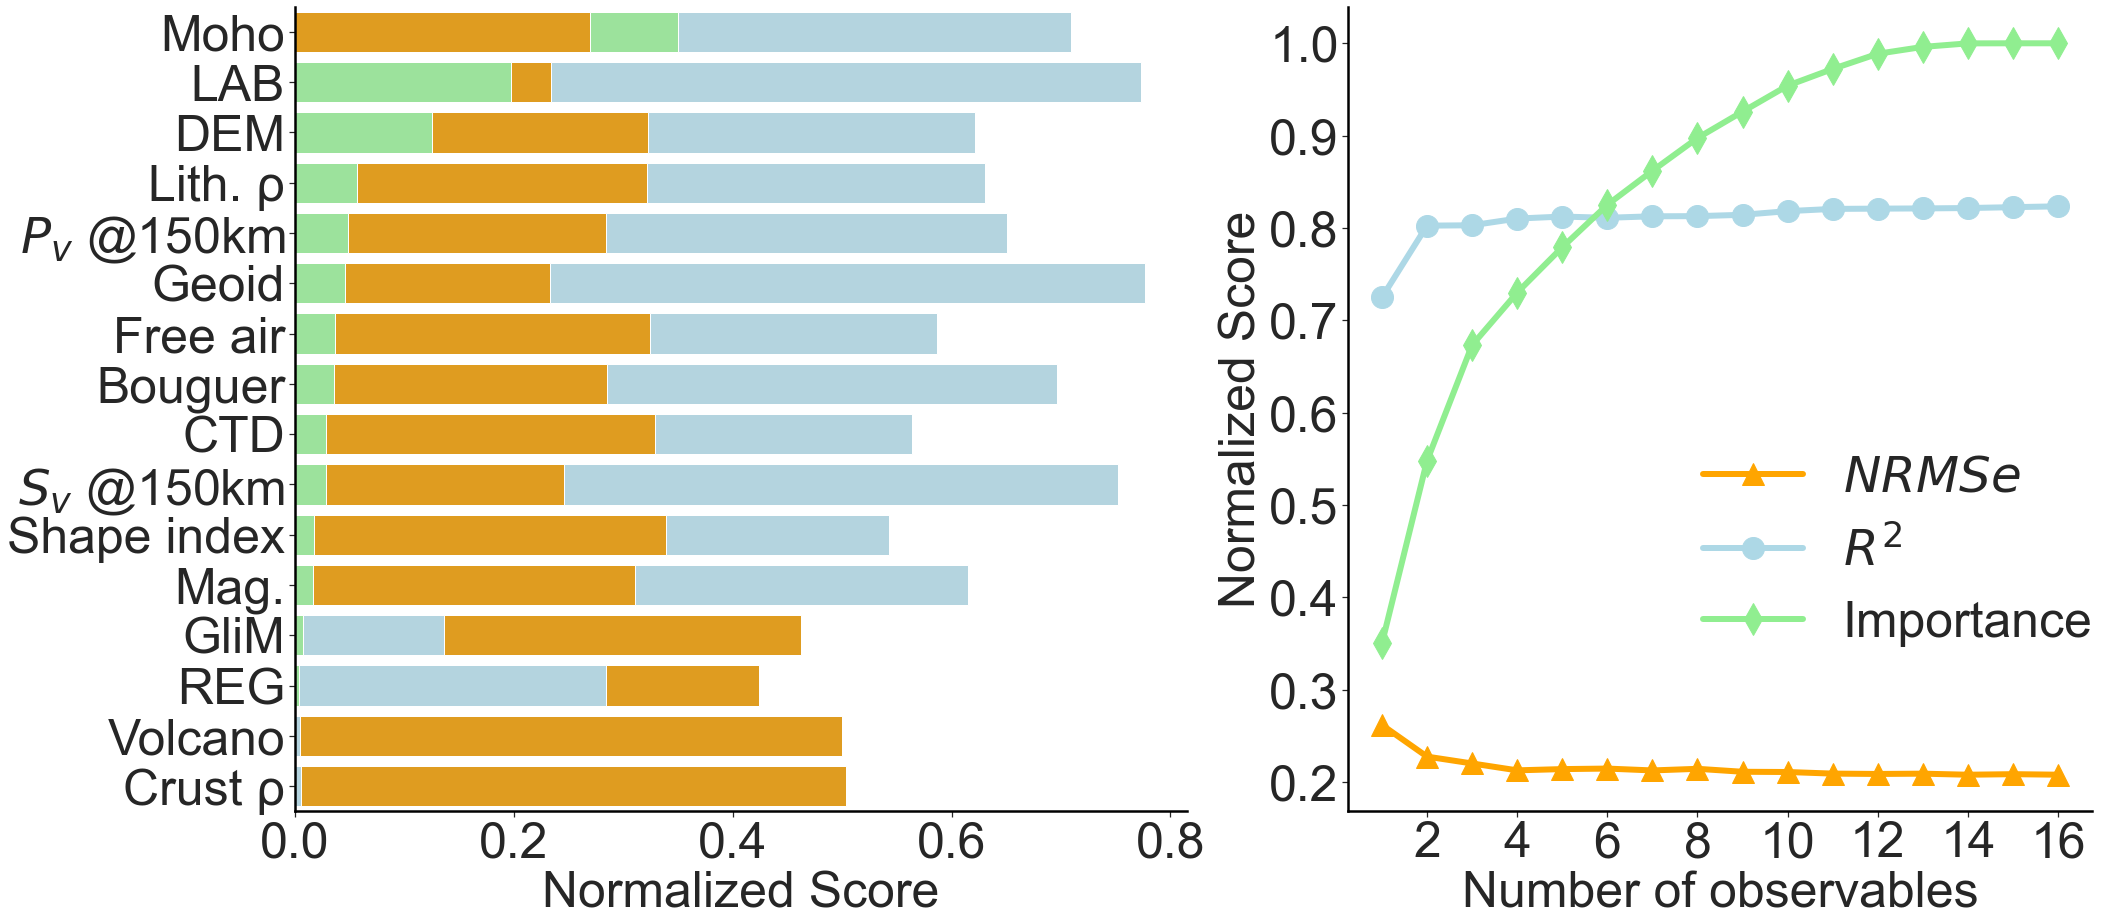

In [25]:
mask_RV_NRMSE = (feature_importance['RI'] < feature_importance['NRMSe']) & (feature_importance['NRMSe'] < feature_importance['R2'])

mask_NRMSE_RV = (feature_importance['NRMSe'] < feature_importance['RI']) & (feature_importance['RI'] < feature_importance['R2']) 
    
mask_R2_RV = (feature_importance['R2'] < feature_importance['RI']) & (feature_importance['RI'] < feature_importance['NRMSe'])


mask_RV_R2 = (feature_importance['RI'] < feature_importance['R2']) & (feature_importance['R2'] < feature_importance['NRMSe'])

mask_NRMSE_R2 = (feature_importance['NRMSe'] < feature_importance['R2']) & (feature_importance['R2'] < feature_importance['RI']) 


mask_R2_NRMSE = (feature_importance['R2'] < feature_importance['NRMSe']) & (feature_importance['NRMSe'] < feature_importance['RI'])



#feature importance 
# Get selected features data set
# should be scaled
fig, axes = plt.subplots(1,2, figsize=(30, 13),gridspec_kw={'width_ratios': [3, 2.5]})
sns.set(style="whitegrid")

plt.rcParams.update(plt_params)



axes.ravel()
#sns.set(style="whitegrid", color_codes=True, font_scale = 3)



###1
if mask_RV_NRMSE.any():
    sns.barplot(x = feature_importance['R2'].values * mask_RV_NRMSE.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance['NRMSe'].values * mask_RV_NRMSE.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    sns.barplot(x = feature_importance["RI"].values * mask_RV_NRMSE.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

###2
if mask_NRMSE_RV.any():
    sns.barplot(x = feature_importance['R2'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance["RI"].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

    sns.barplot(x = feature_importance['NRMSe'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    

###3
if mask_R2_RV.any():
    sns.barplot(x = feature_importance['NRMSe'].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )


    sns.barplot(x = feature_importance["RI"].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )


    
    sns.barplot(x = feature_importance['R2'].values * mask_R2_RV.astype(int).values, 
            y = feature_importance.index, 
            ax=axes[0], color='lightblue',
            )
    

###4
if mask_RV_R2.any():
    
    sns.barplot(x = feature_importance['NRMSe'].values * mask_RV_R2.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    
    sns.barplot(x = feature_importance['R2'].values * mask_RV_R2.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )

    sns.barplot(x = feature_importance["RI"].values * mask_RV_R2.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

###5
    
if mask_NRMSE_RV.any():
    sns.barplot(x = feature_importance['R2'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance["RI"].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

    sns.barplot(x = feature_importance['NRMSe'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    
####6
if mask_R2_RV.any():
    
   
    sns.barplot(x = feature_importance['NRMSe'].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    sns.barplot(x = feature_importance["RI"].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )
    
    sns.barplot(x = feature_importance['R2'].values * mask_R2_RV.astype(int).values, 
            y = feature_importance.index, 
            ax=axes[0], color='lightblue',
            )
    
    
### optimal

'''
if mask_RV_NRMSE.any():
    sns.barplot(x = feature_importance.loc[mask_RV_NRMSE[0:11], 'R2'].values, 
                y = feature_importance.loc[mask_RV_NRMSE[0:11], 'R2'].index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance.loc[mask_RV_NRMSE[0:11],'NRMSe'].values, 
                y = feature_importance.loc[mask_RV_NRMSE[0:11],'NRMSe'].index, 
                ax=axes[0], color='orange', label='NRMSe',
                )
    sns.barplot(x = feature_importance.loc[mask_RV_NRMSE[0:11],"RI"].values, 
                y = feature_importance.loc[mask_RV_NRMSE[0:11],"RI"].index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )
    
''' 


axes[0].set_ylabel('')
axes[0].grid(False)



#axes[0].patch.set_edgecolor('black')  
#axes[0].patch.set_linewidth('3') 
# Hide the right and top spines
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')





axes[0].locator_params(axis='x', nbins=7)
#axes[0].legend(loc=[.55, .6], framealpha=0.5)

#axes[0].set_title(f'{sub_figs[0]})', loc ='left', pad=20, size=40,  y=1.1)
axes[0].set_xlabel("Normalized Score")


for key, score in scorings.items():
    #selected_features = feature_names[results[key].support_].tolist()
    # Get Performance Data
    #print(f"Optimal number of features for {key} : {results[key].n_features_}")
    if key == 'NRMSe':
        #results[key].support_rfecv_df = pd.DataFrame(results[key].ranking_,index=X_afr_hr.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)

        axes[1].plot(score_progression.index, 
                 score_progression['NRMSe_RFECV'], color='orange', linewidth=6,
                   marker="^", label='$NRMSe$', markersize=22,)


    else:
        axes[1].plot(score_progression.index,
                 score_progression['R2_RFECV'], color='lightblue', 
                     linewidth=6, marker="o",  label='$R^2$', markersize=22,
                       )


axes[1].plot(score_progression.index, 
         score_progression['CUMSUM'], linewidth=6, 
            color='lightgreen',  marker="d", 
             label=f'''Importance''', markersize=22,)


axes[1].set_xlabel("Number of observables")

axes[1].set_ylabel("Normalized Score")
axes[1].legend(loc=[.45, .18], frameon=False)
#axes[1].legend(loc=[.01, .7])
#plt.axesvline(results[key].n_features_ ,color='r')
#axes[1].set_title(f'{sub_figs[1]})', loc ='left', pad=20, size=40,  y=1.1)
axes[1].locator_params(axis='y', nbins=10)
axes[1].locator_params(axis='x', nbins=9)
axes[1].grid(False)

axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')




# Tight layout
plt.tight_layout()


# Save Figure
#fig.savefig(dir_p/'fig'/'presentation'/"fig_p6d.jpeg", bbox_inches='tight', dpi=300 )
#fig.savefig(DIR/'fig'/"fig_8.pdf", bbox_inches='tight', dpi=300 )
#fig.savefig(DIR/'fig'/"fig_8.jpg", bbox_inches='tight', dpi=300 )

# Modeling

In [26]:

sorted_features = obs.reset_index(drop=False).set_index('LABELS')



selected_features = []
for best_feature in range(16,3, -1):
    selected_features.extend([sorted_features.loc[feature_importance.index, 'OBS_REF'].values[0 :best_feature]])

selected_features

[array(['MOHO', 'LAB', 'DEM', 'RHO_L', 'PV', 'GEOID', 'FA', 'BG', 'CTD',
        'SV', 'SI', 'EMAG2_CLASS', 'GLIM', 'REG', 'VOLC_DIST_W', 'RHO_C'],
       dtype=object),
 array(['MOHO', 'LAB', 'DEM', 'RHO_L', 'PV', 'GEOID', 'FA', 'BG', 'CTD',
        'SV', 'SI', 'EMAG2_CLASS', 'GLIM', 'REG', 'VOLC_DIST_W'],
       dtype=object),
 array(['MOHO', 'LAB', 'DEM', 'RHO_L', 'PV', 'GEOID', 'FA', 'BG', 'CTD',
        'SV', 'SI', 'EMAG2_CLASS', 'GLIM', 'REG'], dtype=object),
 array(['MOHO', 'LAB', 'DEM', 'RHO_L', 'PV', 'GEOID', 'FA', 'BG', 'CTD',
        'SV', 'SI', 'EMAG2_CLASS', 'GLIM'], dtype=object),
 array(['MOHO', 'LAB', 'DEM', 'RHO_L', 'PV', 'GEOID', 'FA', 'BG', 'CTD',
        'SV', 'SI', 'EMAG2_CLASS'], dtype=object),
 array(['MOHO', 'LAB', 'DEM', 'RHO_L', 'PV', 'GEOID', 'FA', 'BG', 'CTD',
        'SV', 'SI'], dtype=object),
 array(['MOHO', 'LAB', 'DEM', 'RHO_L', 'PV', 'GEOID', 'FA', 'BG', 'CTD',
        'SV'], dtype=object),
 array(['MOHO', 'LAB', 'DEM', 'RHO_L', 'PV', 'GEOID', 'FA', 'B

In [27]:
pipeline_dict = {}
grids_dict = {}
selected_features_dict = {}


best_features = ['16', '15','14', '13','12', '11','10',
                 '09','08', '07','06','05','04'
                 ]


scoring = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

kfold =10
cv = KFold(n_splits=kfold, random_state=None, shuffle=True)


label = 'AFR' 

for best_feature, selected_feature in tqdm_notebook(
    zip(best_features ,selected_features) , total=len(best_features)   , desc = 'Training: '):

    y_Afr = Afr_OD_ra_hr[target]
    x_Afr = Afr_OD_ra_hr[selected_feature]
    
    
    regressor = RandomForestRegressor()


    numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[ ("preprocessor", preprocessor),  ("regressor", regressor)]


    # Initialize Pipeline object
    model_pipeline= Pipeline(steps = steps)
    model_pipeline.set_params(**best_params)


  
    trained_model = model_pipeline.fit(x_Afr, y_Afr )
    
   

    ######### save

   
    pipeline_dict[f'RFE_{best_feature}'] = trained_model
    
    #grids_dict[f'RFE_{best_feature}'] =  ds_afr[selected_feature].to_array().values
    
    selected_features_dict[f'RFE_{best_feature}']   = selected_feature

    print(f'RFE_{best_feature} fitting is terminated' )




Training:   0%|          | 0/13 [00:00<?, ?it/s]

RFE_16 fitting is terminated
RFE_15 fitting is terminated
RFE_14 fitting is terminated
RFE_13 fitting is terminated
RFE_12 fitting is terminated
RFE_11 fitting is terminated
RFE_10 fitting is terminated
RFE_09 fitting is terminated
RFE_08 fitting is terminated
RFE_07 fitting is terminated
RFE_06 fitting is terminated
RFE_05 fitting is terminated
RFE_04 fitting is terminated


In [28]:
grids_dict = {}

n_features = ['16','15', '14', '13', '12', '11', '10', '09', '08', '07', '06', '05', '04']
for selected_feature, n_feature in tqdm_notebook(zip(selected_features, n_features), 
                                                 total = len(n_features),
                                      desc= 'Import from grid: ' ):
    df = pd.DataFrame({'X': ds_afr_hr.XV.values.ravel(), 'Y': ds_afr_hr.YV.values.ravel()})

    for feature in tqdm_notebook(selected_feature , 
                                            desc=f'{selected_feature}: ', leave=False ):
        sleep(0.01)
        df[feature] = ds_afr_hr[feature].values.ravel()
    grids_dict[f'RFE_{n_feature}'] = df[selected_feature]

Import from grid:   0%|          | 0/13 [00:00<?, ?it/s]

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID' 'FA' 'BG' 'CTD' 'SV' 'SI'
 'EMAG2_CLASS' 'GLIM' 'REG' 'VOLC_DIST_W' '…

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID' 'FA' 'BG' 'CTD' 'SV' 'SI'
 'EMAG2_CLASS' 'GLIM' 'REG' 'VOLC_DIST_W']:…

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID' 'FA' 'BG' 'CTD' 'SV' 'SI'
 'EMAG2_CLASS' 'GLIM' 'REG']:   0%|        …

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID' 'FA' 'BG' 'CTD' 'SV' 'SI'
 'EMAG2_CLASS' 'GLIM']:   0%|          | 0/…

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID' 'FA' 'BG' 'CTD' 'SV' 'SI'
 'EMAG2_CLASS']:   0%|          | 0/12 [00:…

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID' 'FA' 'BG' 'CTD' 'SV' 'SI']:   0%|          | 0/11 [00:00<?, ?it/s]

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID' 'FA' 'BG' 'CTD' 'SV']:   0%|          | 0/10 [00:00<?, ?it/s]

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID' 'FA' 'BG' 'CTD']:   0%|          | 0/9 [00:00<?, ?it/s]

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID' 'FA' 'BG']:   0%|          | 0/8 [00:00<?, ?it/s]

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID' 'FA']:   0%|          | 0/7 [00:00<?, ?it/s]

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV' 'GEOID']:   0%|          | 0/6 [00:00<?, ?it/s]

['MOHO' 'LAB' 'DEM' 'RHO_L' 'PV']:   0%|          | 0/5 [00:00<?, ?it/s]

['MOHO' 'LAB' 'DEM' 'RHO_L']:   0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
predictions_df = {}
xs = range(len(ds_afr_hr.X))
ys = range(len(ds_afr_hr.Y))
nn = (len(ds_afr_hr.Y), len( ds_afr_hr.X))


hq_gt = Afr_OD_ra_hr[[grid_index_afr, target]].set_index(grid_index_afr)
hq_gt.index.names = ['index']

for key, pipeline  in tqdm_notebook(pipeline_dict.items() , 
                                            desc=f'Modelling: '):
    print(key)
    pipeline = pipeline_dict[key]
    AFR_Q_RFR = np.zeros(nn) # predicted HF value
    AFR_grid = grids_dict[key][selected_features_dict[key]]
    predictions_df[key] = pd.DataFrame({'X': ds_afr_hr.XV.values.ravel(), 'Y': ds_afr_hr.YV.values.ravel()})

    if 'GLIM' in selected_features_dict[key]:
        AFR_grid['GLIM']  = AFR_grid['GLIM'].astype('int').astype('category')
    if 'REG' in selected_features_dict[key]:
        AFR_grid['REG']  = AFR_grid['REG'].astype('int').astype('category')
    predictions_df[key]['Prediction'] = pipeline.predict(AFR_grid).reshape(-1,1)
    predictions_df[key].index.names = ['index']
    final_df = pd.merge(predictions_df[key], hq_gt,  how="left", on="index")
    final_df.to_csv(DIR/'Grids'/'Outputs'/f'{key}_ra.csv' , index=False, header=True, sep='\t')
    ds_afr_hr[key] = (('Y', 'X'), predictions_df[key]['Prediction'].values.reshape(nn) )
    
ds_afr_hr.to_netcdf(DIR/'Grids'/'Outputs'/"ds_afr_rfr_ra_hr.nc", mode='w', 
                    engine='netcdf4')

Modelling:   0%|          | 0/13 [00:00<?, ?it/s]

RFE_16
RFE_15
RFE_14
RFE_13
RFE_12
RFE_11
RFE_10
RFE_09
RFE_08
RFE_07
RFE_06
RFE_05
RFE_04


# RFECV

In [30]:
sub_figs = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

#create two datsets for A ratibng and b ratings
hq_f = DIR / 'Dataset'/ 'References'/'q_Heat_Flow'/'NGHF.csv'

elev_cut = -1000

record_total = pd.read_csv(hq_f)

record_total = record_total.rename(columns={'heat-flow (mW/m2)': target, 'longitude': 'lon', 'latitude': 'lat'})






hq_afr_lat = record_total[record_total['lat'].between(afr_lat_min, afr_lat_max, inclusive='both')]
record_total_afr = hq_afr_lat[hq_afr_lat['lon'].between(afr_lon_min, afr_lon_max, inclusive='both')]



hq_no_pole_afr = record_total_afr.dropna(subset = ['lon', 'lat', target])

hq_no_pole_afr = hq_no_pole_afr[hq_no_pole_afr[target].between(hq_lower_bound, hq_upper_bound, inclusive='both')]


#hq_no_pole_afr = hq_clean[hq_clean['lat'].between(world_lat_min, world_lat_max, inclusive='both')]
hq_deep_afr = hq_no_pole_afr[(hq_no_pole_afr['elevation (m)']>elev_cut)][['lon', 'lat',target]]



hq_final_a_afr = hq_no_pole_afr[(hq_no_pole_afr ['code6']=='A') & (hq_no_pole_afr ['elevation (m)']>elev_cut)][['lon', 'lat',target]]
hq_final_b_afr= hq_no_pole_afr[(hq_no_pole_afr ['code6']=='B') & (hq_no_pole_afr ['elevation (m)']>elev_cut)][['lon', 'lat',target]]





In [31]:
Best_feature = 11

obs = obs.reset_index(drop=False).set_index('LABELS')

reduced_datsets = obs.loc[feature_importance.iloc[0:Best_feature, 0].index, :]
reduced_datsets = reduced_datsets.reset_index()




obs = obs.reset_index(drop=False).set_index('OBS_AFR')

reduced_datsets

LABELS OBS_REF      OBS_AFR   LABELS_gmt            UNITS  UNITS_gmt          V_RANGE      V_RANGE_AFR       CMAPS
0           Moho    MOHO         MOHO         Moho               km         km         (15, 60)         (20, 50)  SCM/bamako
1            LAB     LAB          LAB          LAB               km         km         (0, 300)        (50, 250)  SCM/bamako
2            DEM     DEM          DEM          DEM                m          m    (-2200, 2200)    (-2200, 2200)  SCM/oleron
3        Lith. ρ   RHO_L        RHO_L    Lith. rho         kg/m$^3$  kg/m@+3@+     (3260, 3360)     (3260, 3360)  SCM/batlow
4   $P_v$ @150km      PV  PV_Velocity  P@_v@ 150km  $\delta$$P_v$ %       km/s    (-0.02, 0.02)    (-0.02, 0.02)    SCM/roma
5          Geoid   GEOID        GEOID        Geoid                m          m        (-45, 45)        (-45, 45)  SCM/bamako
6       Free air      FA           FA     Free air             mGal       mGal      (-100, 100)      (-100, 100)    SCM/broc
7        Bouguer      BG           BG      Bouguer             mGal       mGal      (-100, 100)      (-100, 100)    SCM/broc
8            CTD     CTD          CTD          CTD               km         km          (0, 50)          (0, 50)  SCM/bamako
9   $S_v$ @150km      SV  SV_Velocity  S@_v@ 150km  $\delta$$S_v$ %       km/s  (-0.075, 0.075)  (-0.075, 0.075)    SCM/roma
10   Shape index      SI           SI  Shape index               si         si          (-1, 1)          (-1, 1)    SCM/broc

In [37]:


#proj=f"l135/-25/-45/-10/2c"
region_gmt= [afr_lon_min, afr_lon_max,afr_lat_min, afr_lat_max]
projection = 'M5.4i'


frames = ['wNes', 'wNes','wNEs','Wnes', 'wnes', 'wnes','wnEs','WneS', 'wneS', 'wneS','wnES','wnES']

fig = pygmt.Figure()

pygmt.config(FONT='25p')

with fig.subplot(
    nrows=6,
    ncols=4,
    #figsize=("30c", "15c"),  # width of 15 cm, height of 6 cm
    subsize = ("13.5c", "13.5c"),
    autolabel=['A)+o0.3/-1.5'],
    margins=["0.3c", "2.7c"],  # horizontal 0.3 cm and vertical 0.2 cm margins
    #title=model[3:],
    #sharex="bt",  # shared x-axis on the bottom side
    sharey=True,  # shared y-axis on the left side
    #frame="WSrt",
):

    with fig.set_panel(panel=0):

        cmap= pygmt.makecpt(
            cmap=DIR/'GMT'/'temperature.cpt', #temp 19lev
            #cmap='lajolla',
            series='40/120',
            #truncate = '40/140',
            #continuous=True,
            reverse=False,
        )

        fig.basemap(region=region_gmt, projection=projection, frame='WNes', panel=0)

      


        fig.coast(
            projection=projection,
            #shorelines=0.5,
            water="lightblue", 
            shorelines="0.1p,black",
            borders=["1/0.001p,black"],
            lakes="lightblue",
            rivers="lightblue" ,
            land='darkgrey'
            #borders=["1/0.5p,black"],
            #water='white',
            
            )

        fig.plot(x=hq_final_a_afr.lon, y=hq_final_a_afr.lat,  cmap=True, projection=projection,
             color=hq_final_a_afr[target], #label=f"'A Rating'",
                      pen="0.01p,darkgrey", style="c0.21c")
        fig.plot(x=hq_final_b_afr.lon, y=hq_final_b_afr.lat,  cmap=True, projection=projection,
             color=hq_final_b_afr[target], #label="'B Rating'",
                      pen="0.01p,darkgrey", style="c0.21c")
        fig.colorbar(frame=["af", f"x+lGHF\t\t[mW/m@+2@+]"], 
                     position=f"g{str(afr_lon_min-1)}/{str(afr_lat_min-8.2)}+w12.5c/0.5c+h+e")
    

    for  cmap_i, grid_label, v_range, label_i ,unit, importance, panel,  in zip(
         reduced_datsets['CMAPS'],  reduced_datsets['OBS_AFR'],
                    reduced_datsets['V_RANGE_AFR'], reduced_datsets['LABELS_gmt'],
        reduced_datsets['UNITS_gmt'], feature_importance['RI'],
        list(range(len(reduced_datsets)))):

        
        with fig.set_panel(panel=panel+1):
            if cmap_i =='bilbao':
                cmap = pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range[0]}/{v_range[1]}',
                #continuous=True,
                reverse=True,
                )
            elif unit == 'class':
                cmap = pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range[0]}/{v_range[1]+1}/1',
                categorical=list(range(v_range[0],v_range[1]+1)),
                #continuous=True,
                )
            elif grid_label in ['SV_Velocity', 'PV_Velocity']:
                cmap = pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{ds_afr_hr[grid_label].min().values}/{ds_afr_hr[grid_label].max().values}',
                #continuous=True,
                reverse=False,
                )
            elif grid_label == 'EMAG2':
                cmap = pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range[0]}/{v_range[1]}',
                #continuous=True,
                reverse=False,
                )
            else:
                cmap = pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range[0]}/{v_range[1]}',
                #continuous=True,
                reverse=False,
                )
                

            fig.basemap(region=region_gmt, projection=projection, frame=frames[panel], panel=panel+1)



            fig.grdimage(
                 grid=ds_afr_hr[grid_label], # xarray.DataArray containing VSV values
                 region=region_gmt,
                 projection=projection,
                     cmap=cmap,

                #shading='+a45+nt0.5'
                #shading=dgrid
            )





            fig.coast(
                projection=projection,
                #shorelines=0.5,
                water="lightblue", 
                shorelines="0.1p,black",
                borders=["1/0.001p,black"],
                lakes="lightblue",
                rivers="lightblue" ,
                #borders=["1/0.5p,black"],
                #water='white',
                )

            #print(f'{importance} {label_i}')
            #fig.colorbar(frame=["af", f'x+l"{label_i}"\t\t"[{unit}]"\t\t({str(round(importance*100,1))}\%)',
            fig.colorbar(frame=["af", f'x+l"{label_i}"\t\t"[{unit}]"',                           ],
                    position=f"g{str(afr_lon_min-1)}/{str(afr_lat_min-8.2)}+w12.5c/0.5c+h+e")
            #print(label_i)
            #print(unit)
      

 

fig.show(width=800)


#fig.savefig(DIR/'fig'/"fig_3.pdf", dpi=300 )
#fig.savefig(DIR/'fig'/"fig_3.jpg", dpi=300 )